[9.79305846437406, 9.72038918086481, 9.64398655264662, 9.563850579719489, 9.479981262083411, 9.392378599738393, 9.301042592684432, 9.205973240921526, 9.107170544449678, 9.004634503268887, 8.898365117379154, 8.790766792194812, 8.687913909545424, 8.589806469430986, 8.496444471851499, 8.407827916806962, 8.323956804297378, 8.244831134322746, 8.170450906883065, 8.100816121978335, 8.035926779608555, 7.972167903719038, 7.904945200085895, 7.834258668709123, 7.760108309588725, 7.682494122724698, 7.601416108117045, 7.516874265765763, 7.4288685956708544, 7.337399097832318, 7.242465772250155, 7.146930907738979, 7.052733819540177, 6.959874507653749, 6.868352972079696, 6.778169212818017, 6.689323229868712, 6.601815023231782, 6.515644592907226, 6.430811938895045, 6.347317061195237, 6.264884649081499, 6.183219616218727, 6.102321962606919, 6.022191688246076, 5.942828793136199, 5.864233277277287, 5.7864051406693395, 5.709344383312357, 5.6330510052063385, 5.557462900912895, 5.481261398547236, 5.404376736

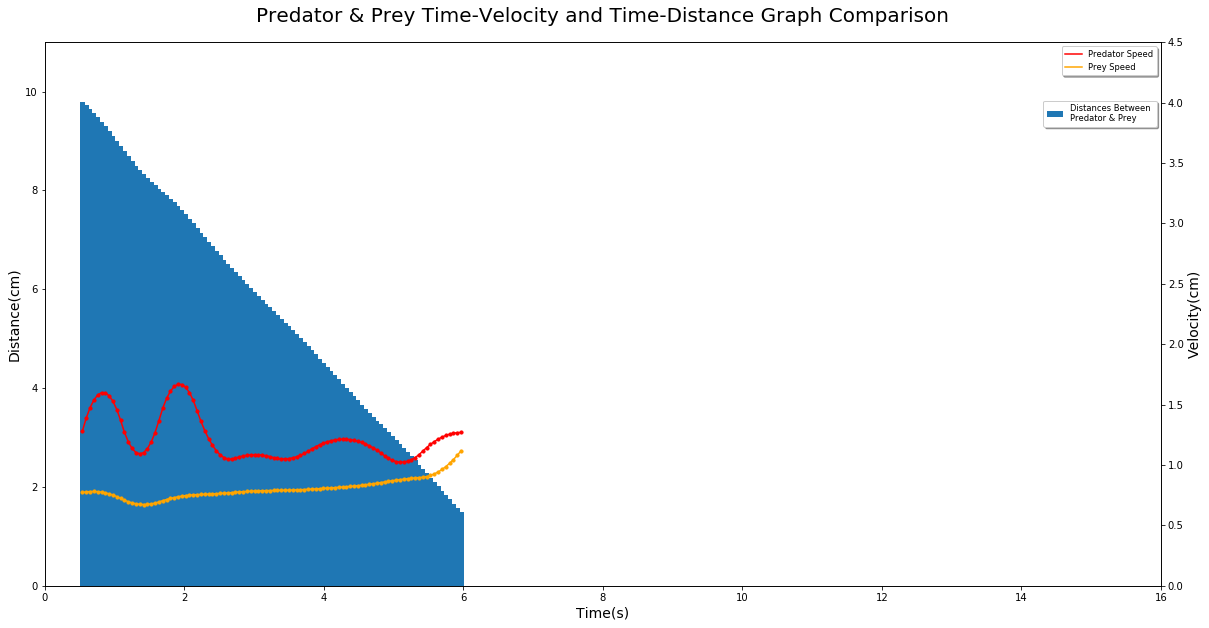

100


In [1]:
import numpy as np
from ipynb.fs.full.ppp_curve import without_nans_pdr as wnpdr
from ipynb.fs.full.ppp_curve import without_nans_pr as wnpr
from ipynb.fs.full.ppp_curve import without_nans_distance as wnd
from ipynb.fs.full.ppp_curve import videoLength
from ipynb.fs.full.ppp_curve import newT_pdrT as time

In [2]:
train = int(len(time)*0.70)
test = int(len(time))-train

In [3]:
import pandas as pd

In [4]:
df_predator = pd.DataFrame(wnpdr, index = time)
df_prey = pd.DataFrame(wnpr, index = time)
df_distance = pd.DataFrame(wnd, index = time)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

In [6]:
predator_training, predator_test = wnpdr[:train], wnpdr[train:]
prey_training, prey_test = wnpr[:train], wnpr[train:]
distance_training, distance_test = wnd[:train], wnd[train:]


In [8]:
def prepare_data(data, chunk):
	x, y =[],[]
	for i in range(len(data)):
		# find the end of this pattern
		end_ix = i + chunk
		# check if we are beyond the sequence
		if end_ix > len(data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = data[i:end_ix], data[end_ix]
		x.append(seq_x)
		y.append(seq_y)
	return np.array(x), np.array(y)

In [9]:
chunk = 5        #chunk of data for training

predator_data = predator_training
prey_data = prey_training
distance_data = distance_training

# split into training samples
x_pdr_train, y_pdr_train = prepare_data(predator_data, chunk)
x_pr_train, y_pr_train = prepare_data(prey_data, chunk)
x_distance_train, y_distance_train = prepare_data(distance_data, chunk)

predator_data = predator_test
prey_data = prey_test
distance_data = distance_test

# split into test samples
x_pdr_test, y_pdr_test = prepare_data(predator_data, chunk)
x_pr_test, y_pr_test = prepare_data(prey_data, chunk)
x_distance_test, y_distance_test = prepare_data(distance_data, chunk)

len(y_pdr_train)

65

In [10]:
n_features = 1

x_pdr_train = x_pdr_train.reshape((x_pdr_train.shape[0], x_pdr_train.shape[1], n_features))
x_pr_train = x_pr_train.reshape((x_pr_train.shape[0], x_pr_train.shape[1], n_features))
x_distance_train = x_distance_train.reshape((x_distance_train.shape[0], x_distance_train.shape[1], n_features))

x_pdr_test = x_pdr_test.reshape((x_pdr_test.shape[0], x_pdr_test.shape[1], n_features))
x_pr_test = x_pr_test.reshape((x_pr_test.shape[0], x_pr_test.shape[1], n_features))
x_distance_test = x_distance_test.reshape((x_distance_test.shape[0], x_distance_test.shape[1], n_features))

x_pdr_train.shape

(65, 5, 1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [12]:
def LSTM_Func(regressor, n_steps, n_features, x, y, X, Y):
    #model = Sequential()
    regressor.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    #regressor.add(Dropout(0.2))
    
    regressor.add(LSTM(50, activation='relu', return_sequences=True))
    #regressor.add(Dropout(0.2))
    
    regressor.add(LSTM(50, activation='relu'))
    #regressor.add(Dropout(0.2))
    
    regressor.add(Dense(1))
    regressor.compile(optimizer='adam', loss='mse')
    # fit model
    regressor.fit(x, y, validation_data = (X, Y), epochs=300, verbose=1, batch_size = 64)

In [13]:
regressor_pdr = Sequential()
regressor_pr = Sequential()
regressor_distance = Sequential()

LSTM_Func(regressor_pdr, chunk, n_features, x_pdr_train, y_pdr_train, x_pdr_test, y_pdr_test)
LSTM_Func(regressor_pr, chunk, n_features, x_pr_train, y_pr_train, x_pr_test, y_pr_test)
LSTM_Func(regressor_distance, chunk, n_features, x_distance_train, y_distance_train, x_distance_test, y_distance_test)

Epoch 1/300
2/2 [==============================] - 1s 367ms/step - loss: 1.5823 - val_loss: 1.2701
Epoch 2/300
2/2 [==============================] - 0s 12ms/step - loss: 1.5476 - val_loss: 1.2483
Epoch 3/300
2/2 [==============================] - 0s 14ms/step - loss: 1.5224 - val_loss: 1.2250
Epoch 4/300
2/2 [==============================] - 0s 13ms/step - loss: 1.4954 - val_loss: 1.1994
Epoch 5/300
2/2 [==============================] - 0s 12ms/step - loss: 1.4659 - val_loss: 1.1706
Epoch 6/300
2/2 [==============================] - 0s 12ms/step - loss: 1.4328 - val_loss: 1.1386
Epoch 7/300
2/2 [==============================] - 0s 11ms/step - loss: 1.3957 - val_loss: 1.1029
Epoch 8/300
2/2 [==============================] - 0s 11ms/step - loss: 1.3541 - val_loss: 1.0626
Epoch 9/300
2/2 [==============================] - 0s 11ms/step - loss: 1.3066 - val_loss: 1.0164
Epoch 10/300
2/2 [==============================] - 0s 14ms/step - loss: 1.2522 - val_loss: 0.9629
Epoch 11/300
2/2 [

In [14]:
pdr_train_pred, pdr_test_pred = regressor_pdr.predict(x_pdr_train), regressor_pdr.predict(x_pdr_test)
pr_train_pred, pr_test_pred = regressor_pr.predict(x_pr_train), regressor_pr.predict(x_pr_test)
distance_train_pred, distance_test_pred = regressor_distance.predict(x_distance_train), regressor_distance.predict(x_distance_test)



In [15]:
#pdr_train_pred, pdr_test_pred = scaler.inverse_transform(pdr_train_pred), scaler.inverse_transform(pdr_test_pred)
#pr_train_pred, pr_test_pred = scaler.inverse_transform(pr_train_pred), scaler.inverse_transform(pr_test_pred) 
#distance_train_pred, distance_test_pred = scaler.inverse_transform(distance_train_pred), scaler.inverse_transform(distance_test_pred)



In [16]:
import math
from sklearn.metrics import mean_squared_error

In [17]:
math.sqrt(mean_squared_error(y_pdr_train, pdr_train_pred)*100)

1.4893748581694992

In [18]:
math.sqrt(mean_squared_error(y_pdr_test, pdr_test_pred)*100)

0.822486477340596

In [19]:
math.sqrt(mean_squared_error(y_pr_train, pr_train_pred)*100)

0.23310343165076883

In [20]:
math.sqrt(mean_squared_error(y_pr_test, pr_test_pred)*100)

0.8704192130859257

In [21]:
math.sqrt(mean_squared_error(y_distance_train, distance_train_pred)*100)

0.47490322541318125

In [22]:
math.sqrt(mean_squared_error(y_distance_test, distance_test_pred)*100)

2.1474542492427693

In [23]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30,})

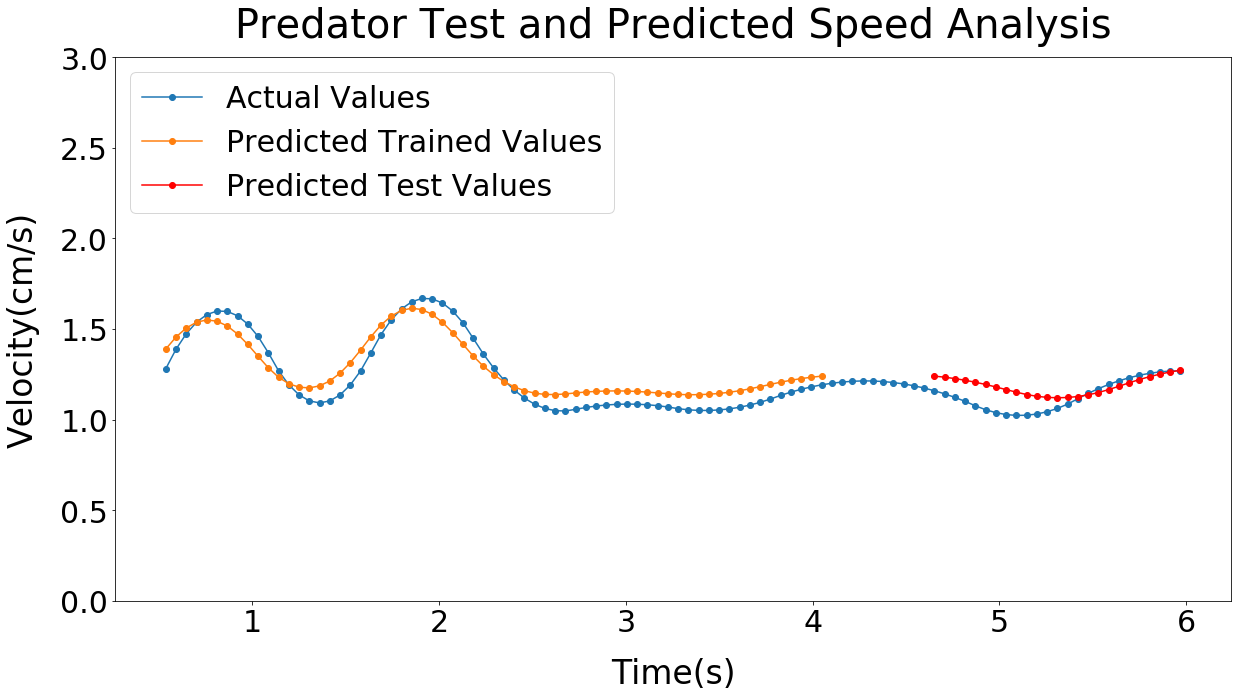

In [24]:
trainPredictPlot = pdr_train_pred
testPredictPlot = pdr_test_pred

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(time, wnpdr, marker = 'o', label = 'Actual Values')
plt.plot(time[:train-chunk], trainPredictPlot, marker = 'o', label = 'Predicted Trained Values')
plt.plot(time[-test+chunk:], testPredictPlot, marker = 'o', color = 'r', label = 'Predicted Test Values')
plt.xlabel('Time(s)', fontsize = 33, labelpad = 20)
plt.ylabel('Velocity(cm/s)', fontsize = 33, labelpad = 20)
plt.ylim([0,3])
plt.title('Predator Test and Predicted Speed Analysis', fontsize = 40, pad = 20)
plt.legend(loc = 'upper left')
plt.show()


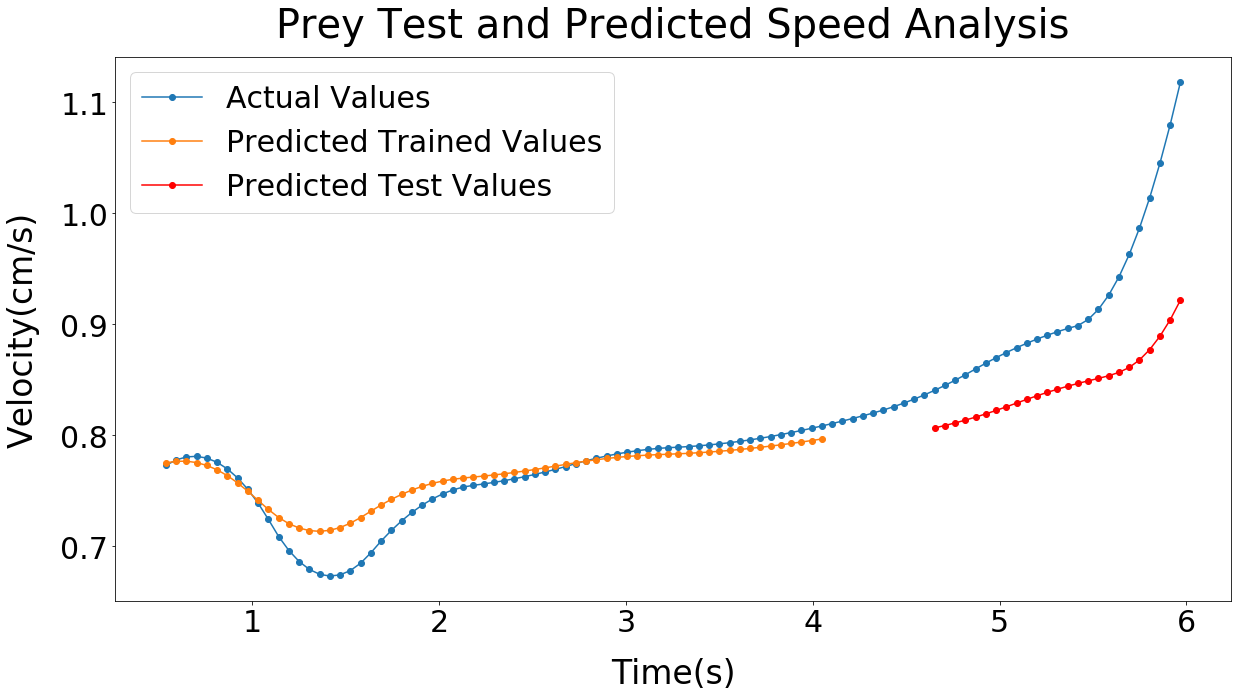

In [25]:
trainPredictPlot = pr_train_pred
testPredictPlot = pr_test_pred

plt.plot(time, wnpr, marker = 'o', label = 'Actual Values')
plt.plot(time[:train-chunk], trainPredictPlot, marker = 'o', label = 'Predicted Trained Values')
plt.plot(time[-test+chunk:], testPredictPlot, marker = 'o', color = 'r', label = 'Predicted Test Values')
plt.xlabel('Time(s)', fontsize = 33, labelpad = 20)
plt.ylabel('Velocity(cm/s)', fontsize = 33, labelpad = 20)
plt.title('Prey Test and Predicted Speed Analysis', fontsize = 40, pad = 20)
plt.legend()
plt.show()

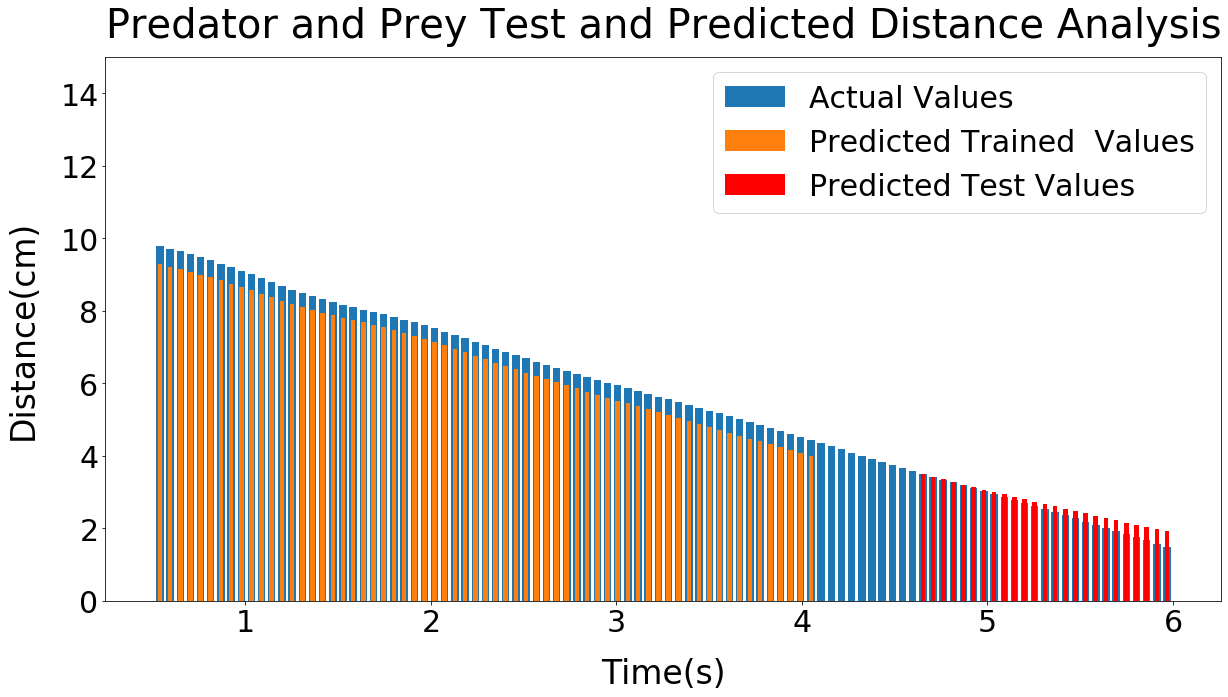

In [35]:
trainPredictPlot = distance_train_pred
trainPredict = []
testPredictPlot = distance_test_pred 
testPredict = []




plt.rcParams["figure.figsize"] = (20,10)
plt.bar(time, wnd, width = 0.04 if videoLength < 10 else 0.07, label = 'Actual Values')

for i in range(len(trainPredictPlot)):
    trainPredict.append(distance_train_pred[i][0])


for j in range(len(testPredictPlot)):
    testPredict.append(distance_test_pred[j][0])

plt.bar(time[:train-chunk], trainPredict, width = 0.025 if videoLength < 10 else 0.05, label = 'Predicted Trained  Values')
plt.bar(time[-test+chunk:], testPredict, width = 0.025 if videoLength < 10 else 0.05, color = 'r', label = 'Predicted Test Values')
plt.xlabel('Time(s)', fontsize = 33, labelpad = 20)
plt.ylabel('Distance(cm)', fontsize = 33, labelpad = 20)
plt.ylim([0,15])
plt.title('Predator and Prey Test and Predicted Distance Analysis', fontsize = 40, pad = 20)
plt.legend()
plt.show()